Sparse multiplication-free narrowband bandpass filtering
====

I think I finally have an efficient way to recognize tones
with reasonable precision
with sparse linear filters without multiplication,
which turns out to pretty much just be Hogenauer filters.
Preliminary calculations suggest the scheme should be able to detect
17 different whistleable musical notes simultaneously
on a 16ksps audio signal
at a cost of about 20 integer additions and subtractions per sample,
most of which are only a few bits wider than the samples themselves.
So far in practice I have been able to recognize an audio tone on my laptop 1000x faster
than real time with Numpy.

It would be surprising if this approach were novel,
and my inability to find it so far in the signal processing literature
probably just demonstrates my unfamiliarity with the field.

The basic scheme
-----

First we run the signal $x_i$ through a couple of integrators,
or [indefinite sum](https://en.wikipedia.org/wiki/Indefinite_sum) or antidifference operators:

$$b_i = x_{i-1} + b_{i-1}$$
$$c_i = b_{i-1} + c_{i-1}$$

A very important optimization this enables is that at this point
we can decimate the signal to four samples per oscillation period of the frequency of interest,
but I'm not going to do that here.

Then we pass that second-order antidifference
through a couple of feedforward
comb filters with lags $l_1, l_2$ to get a trapezoid-shaped finite impulse response
which strongly attenuates signals above the frequency of interest:

$$d_i = c_i - c_{i - l_1}$$
$$e_i = d_i - d_{i - l_2}$$

At this point we have multiplied the signal by a largish integer factor and also gained some precision
by averaging a bunch of samples together.  Rescaling this value to be smaller, so that later additions
don't need to be as wide, may be a good idea.

Now we pass it through another couple of *feedback* comb filters with a lag $l_3$
and a feedback gain of $-1$,
which work as integrators at the frequency of interest (with period $2l_3$)
[and its odd harmonics](https://en.wikipedia.org/wiki/Comb_filter#Frequency_response_2),
but have zero frequency response at even harmonics
and attenuate all other frequencies:

$$f_i = e_i - f_{i - l_3}$$
$$g_i = f_i - g_{i - l_3}$$

Now, to make our impulse response finite again, we use two more feedforward combs
with lags $2nl_3$ and $2ml_3$, where $n$ and $m$ define a trapezoidal time-domain envelope
over which the oscillation persists.  This can be done after an additional decimation step.

$$h_i = g_i - g_{i - 2nl_3}$$
$$j_i = h_i - h_{i - 2ml_3}$$

Each oscillation is, in general, a piecewise-linear approximation of a sinusoidal oscillation, with two
constant (zero-order) segments and $6$ linear (first-order) segments.
Its precise form is determined by the ratios of the lags $l_1, l_2, l_3$.
I don't know what the best approximation to a sine wave is in this form but I don't think it's a triangle wave,
which is what you get when $l_1 = l_2$.

This computation doesn't require any multiplications.  It requires 2 additions per sample ($b$ and $c$),
after which you can decimate to four samples per oscillation; then each of $d$ and $e$ requires one
subtraction per sample, for a total of 8 subtractions per oscillation.  Finally $f$, $g$, $h$ and $j$ require four more subtractions, but those are per window spacing.  A wider window gives you a narrower range of frequencies,
but of course less precise timing.

A more precise approximation of the sinusoid can be obtained by using a piecewise-quadratic or piecewise-cubic
curve instead of a piecewise-linear curve, at the cost of one or two extra integrators and feedforward combs.

For multi-tone detection, the 2 additions per sample can be shared between all the frequencies being detected, but after you are detecting more than about 5 tones or so,
almost all of the work is in steps $d$ and $e$ above, so the cost of using a higher-order approximation (more additions per sample, providing more low-pass filtering) becomes insignificant.

An even lower-cost option is filters with the same center frequency but different Q factors;
this only requires recomputing $f$, $g$, $h$, and $j$, and these only need recomputing once per window
rather than four times per oscillation.

I'm not certain about my assignment of $f$ and $g$ to the lowest sample rate.

An example, step by step
--------

Here I'm using floating-point rather than fixed-width integer arithmetic,
so precision loss would be a problem if this code were applied to real life.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn

In [3]:
matplotlib.style.use('seaborn-poster')
rcParams['figure.figsize'] = 12.8, 4
rcParams['lines.linewidth'] = 1

The simplest way to calculate the impulse response is to start with an impulse.

dtype('float64')

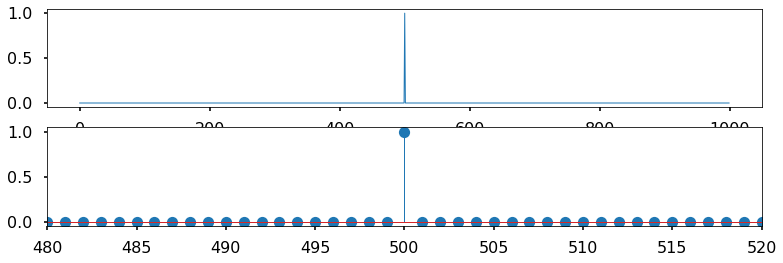

In [4]:
x = zeros(1000)
x[len(x)//2] = 1
subplot(211); plot(x)
subplot(212); stem(x, use_line_collection=True); xlim(480, 520)
x.dtype

First and second integrators, $b$ and $c$:

1000

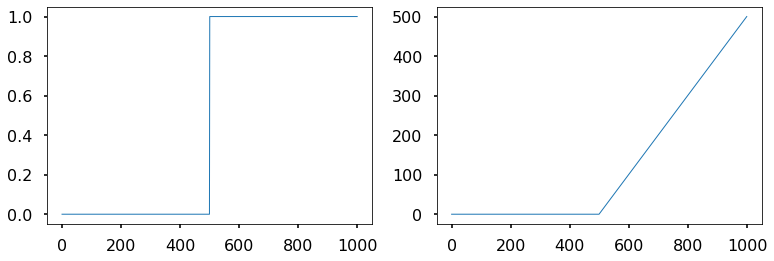

In [5]:
s1 = x.cumsum()
s2 = s1.cumsum()
subplot(121); plot(s1)
subplot(122); plot(s2)
len(s2)

At this point if we were trying to be efficient we would decimate the signal.

First comb, $d$; here $l_1 = 45$.  This shows us the average slope over 45 samples of the previous curve.

<StemContainer object of 3 artists>

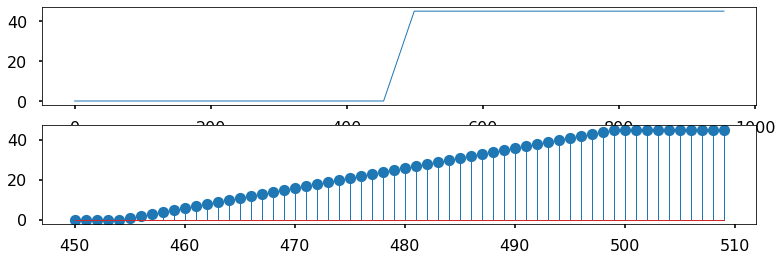

In [6]:
l1 = 45
d1 = s2[l1:] - s2[:-l1]
subplot(211); plot(d1)
subplot(212); stem(range(450, 510), d1[450:510], use_line_collection=True)

The second comb makes our impulse response finite again.  Because $l_2 = 30 \ne l_1$ we get a trapezoid,
not a triangle.

Note that although this is finite it has a rather large amplification of $30 \times 45 = 1350$.  With
these lags you need an extra 11 bits of integer precision above those needed for the original samples.
This number would not be smaller if we had decimated the signal earlier anytime after the integrators,
but at this point you could drop those extra 11 bits of precision to reduce the width of later operations.

(1350.0, 1350)

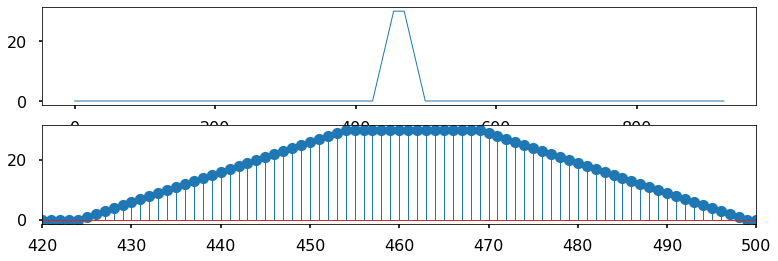

In [7]:
l2 = 30
d2 = d1[l2:] - d1[:-l2]
subplot(211); plot(d2)
subplot(212); stem(d2, use_line_collection=True); xlim(420, 500)
d2.sum(), l1 * l2

Now by applying a feedback comb we excite this hump into oscillation
whose frequency is determined by the lag.  Because its flank overlaps with its
inversion's flank, we get a steeper section, so the resulting sine wave
is a piecewise-linear approximation composed of 8 lines rather than 2, 4, or even 6.

We can see this waveform as an integrator that runs at frequency $\frac 1{120}$
and its odd harmonics
rather than at DC, but if we sample it at a single point, we only get the integration
of the samples with a single phase.  So we have to sample it at two points to get I/Q.

30.0

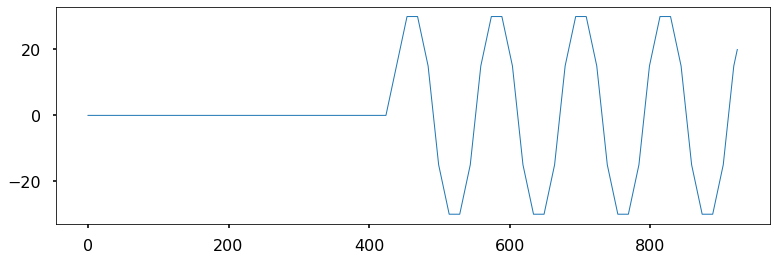

In [8]:
l3 = 60
z1 = zeros(len(d2))
z1[:l3] = d2[:l3]
for i in range(l3, len(z1)):
    z1[i] = d2[i] - z1[i - l3]
plot(z1)
z1.max()

A second level of integration at the same frequency gives us an impulse response that is not only infinite
but actually divergent.

925

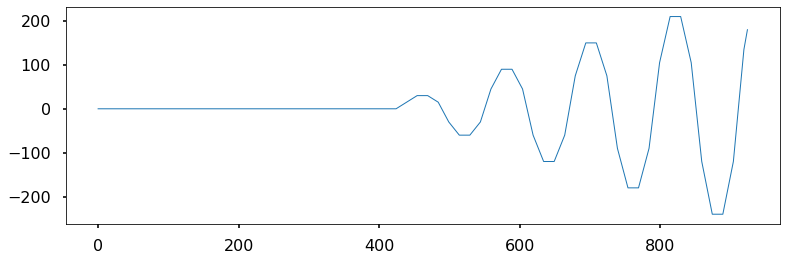

In [9]:
z2 = zeros(len(z1))
z2[:l3] = z1[:l3]
for i in range(l3, len(z2)):
    z2[i] = z1[i] - z2[i - l3]
plot(z2)
len(z2)

Of course if we had done a third pass of integration at the beginning we would have a much closer
approximation to a growing sine wave:

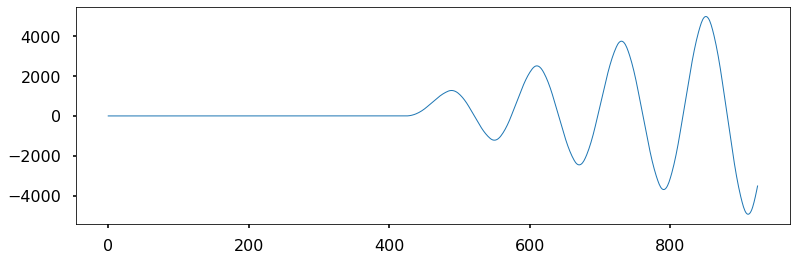

In [10]:
plot(z2.cumsum())

By windowing it with a feedforward comb we can remove the infinite growth,
but of course it's still not BIBO stable.

-930.0

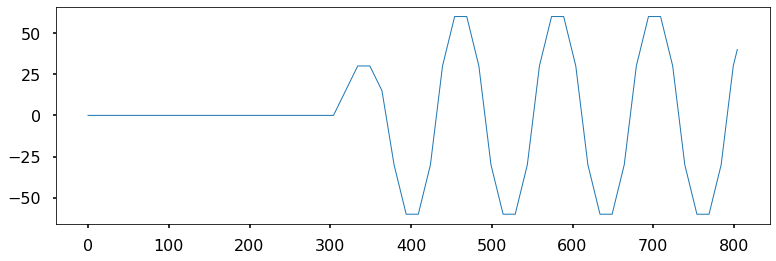

In [11]:
ws1 = 2 * l3
w1 = z2[ws1:] - z2[:-ws1]
plot(w1)
w1.sum()

And now we bring it back down to a finite wavepacket with a final feedforward comb.
This is a pretty narrow window, only $2\frac 12$ oscillations, which means we won't have a very
high Q factor.

0.0

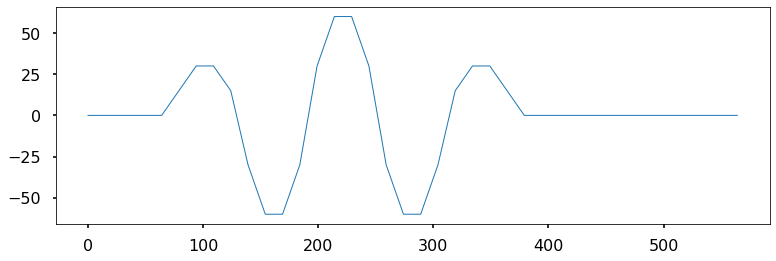

In [12]:
ws2 = 4 * l3
w2 = w1[ws2:] - w1[:-ws2]
plot(w2)
w2.sum()

Note that its perfectly symmetrical shape means that, unlike many recursively implemented filters,
it induces a linear phase shift; sharp time-domain edges in an input signal won't get smeared out over time,
just delayed and some of their frequencies suppressed.

Again, if we had done an additional layer of integration up front this would be much smoother,
and with $90^\circ$ shifted phase.  (The fact that this doesn't require another feedforward comb to
tame its divergence makes me wonder if we can eliminate 
the initial feedforward combs entirely, but I think I might tackle
that question in a different document.)

0.0

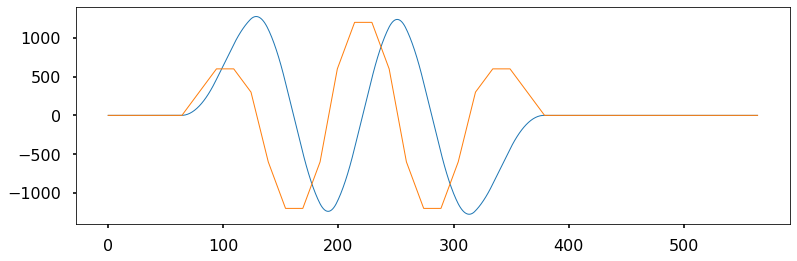

In [13]:
plot(arange(len(w2)), w2.cumsum(), w2*20)
w2.cumsum().sum()

I don't know how to calculate the amplification factor from windowing the sinusoid.  I suspect it's in some sense just the two new lags; but because the overlapping trapezoids cancel partly, it isn't quite that big.

I think the absolute sum (10052)
is the right measure of the amplification here if we're interested in how many extra
bits we need (14) since that's the maximum convolution you can get from filtering a signal whose samples in $\pm 1$.

In [14]:
(w2**2).sum()**0.5, abs(w2).sum(), ws2 * ws1

(653.9877674696982, 10052.0, 28800)

Now that we've computed the time-domain impulse response,
let's look at the power spectral response of this filter.
Aside from the width of its peaks due to its very short window,
the feedback comb filtering suppresses fairly well up to its third harmonic,
and this ad-hoc piecewise-linear approximation of a sinewave suppresses the third
harmonic by about 26 dB.

4.766666666666667

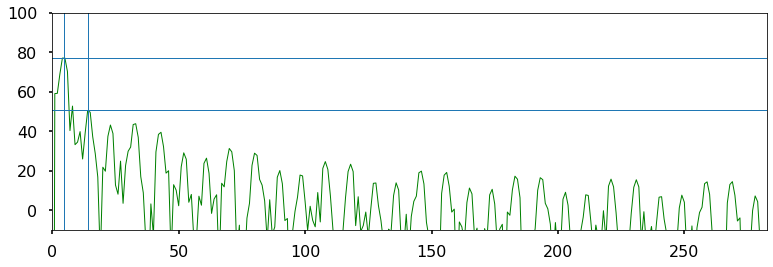

In [15]:
def psr(ir):
    y = 20*log(abs(fft.fft(ir) + 1e-20))/log(10)
    plot(y, 'g')
    ylim(-10, 100)
    xlim(0, len(ir)/2)
    return y
    
psr(w2)
axvline(4.8)
axvline(14.3)
axhline(77)
axhline(51)
14.3/3

The hypothetical third level of integration mentioned above would suppress the third, fifth, etc., harmonics by more, attenuating the third harmonic by 37 dB relative to the fundamental rather than just 26 dB.
A fourth level of integration increases this margin further but has response down to dc, so you'd need another
level of comb filtering if you wanted to do that.

104.05235894443783

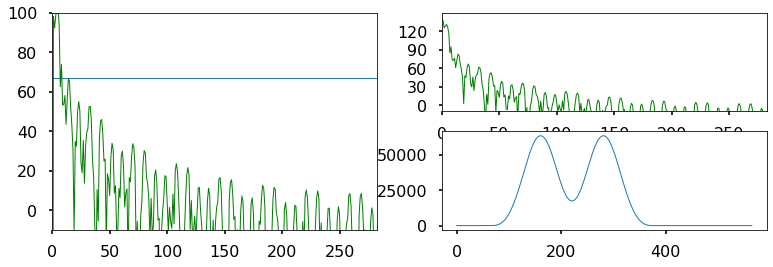

In [16]:
subplot(222); psr(w2.cumsum().cumsum()); ylim(-10, 150); yticks(range(0, 150, 30))
subplot(224); plot(w2.cumsum().cumsum())
subplot(121); axhline(67); psr(w2.cumsum()).max()

Filter design for 1kHz audio tone recognition
----

A semitone is about a 5.9% variation in frequency, so that's how precise your frequency identification
needs to be if you want to distinguish musical notes.  For that purpose you might actually want to include
harmonics rather than excluding them.

In [17]:
2**(1/12)

1.0594630943592953

This works out to a Q factor of something like 17 I think.

In [18]:
1/.059

16.949152542372882

If your filter has an impulse response
with a rectangular envelope containing 17 oscillations, then when it's overlaid over an oscillation
of slightly the wrong frequency such that it's in-phase with the filter at the beginning and 180
degrees out of phase at the end, that's because it contains 16.5 or 17.5 oscillations during that period.
So, in its frequency response, the space between these first two nulls is 1/17 of its frequency, but it can
only match frequencies that are off by 1/34.

This is about what we want for discriminating musical notes, because if it's further away it's closer to the
next note than this one.  But [people can usually distinguish notes that are off by $\frac 18$ of that](https://en.wikipedia.org/wiki/Cent_(music)#Human_perception).

[According to file `whistle-detection`](https://dercuano.github.io/notes/whistle-detection.html)
I can whistle over the range of about 600-1600 Hz, producing an almost
pure sine wave.  This is [roughly the D5 to G6 musical range](https://en.wikipedia.org/wiki/Piano_key_frequencies).
C6, soprano C or high C, is 1046.502 Hz.

What would a filter that matches that note look like?

(29.125, 0.0)

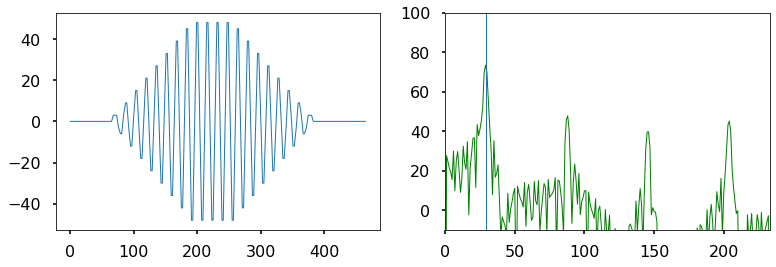

In [19]:
def feedback_negative_comb(x, lag):
    y = zeros(len(x))
    y[:lag] = x[:lag]
    for i in range(lag, len(y)):
        y[i] = x[i] - y[i - lag]
    return y

def feedforward_comb(x, lag):
    return x[lag:] - x[:-lag]

def ralatone(x, l1, l2, l3, n, m):
    c = x.cumsum().cumsum()
    d = feedforward_comb(c, l1)
    e = feedforward_comb(d, l2)
    g = feedback_negative_comb(feedback_negative_comb(e, l3), l3)
    h = feedforward_comb(g, 2 * n * l3)
    return feedforward_comb(h, 2 * m * l3)

def impulse(n):
    x = zeros(n)
    x[len(x)//2] = 1
    return x

fs = 16000
highc = 1046.502
period = round(fs/highc)
half_period = round(period/2)
filt = ralatone(impulse(800), 11, 3, half_period, 12, 8)  # numbers arrived at by fiddling around
#filt = ralatone(impulse(800), 11, 3, half_period, 17, 1)
subplot(121); plot(filt)
subplot(122); psr(filt); axvline(len(filt)/half_period/2)
len(filt)/half_period/2, filt.sum()

While at a glance that doesn't look too terrible, what frequency band is it recognizing?

In [20]:
half_period

8

In [21]:
fs/half_period/2

1000.0

It's trying to recognize 1000 Hz, which is almost half a step low.  Let's see what the actual response is:

(52.152114373693536,
 69.46269033056839,
 73.40831955569794,
 69.90466673666066,
 56.304642379611295)

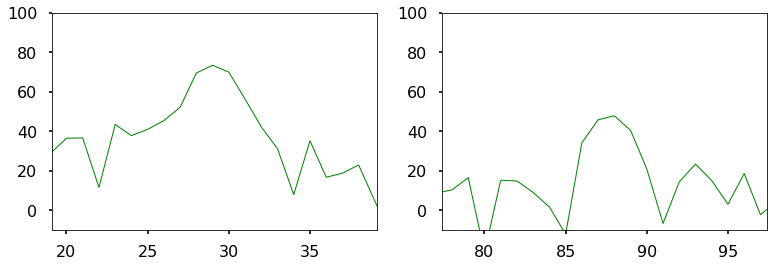

In [22]:
subplot(121); freqs = psr(filt)
xlim(len(filt)/half_period/2 - 10, len(filt)/half_period/2 + 10)
subplot(122); psr(filt); xlim(3*len(filt)/half_period/2-10, 3*len(filt)/half_period/2+10)
freqs[27], freqs[28], freqs[29], freqs[30], freqs[31]

By coincidenct it looks like it's actually a little higher.  So it looks like its response has dropped by about 3.5 dB in the immediately adjoining buckets, so their frequencies are maybe a reasonable approximation of the 3-dB points.

In [23]:
fs/(len(filt)/29), fs/(len(filt)/30), fs/(len(filt)/31)

(995.7081545064377, 1030.0429184549357, 1064.3776824034335)

So maybe its strongest response is about 16 Hz down from high C, and its half-power points are about 35 Hz either way.

In [24]:
12*log(995.7/1030)/log(2)

-0.5863356259018432

So 35 Hz is about 0.6 half-steps, so it's actually barely a selective enough filter to distinguish C6 (1046 Hz) from  B5 (988 Hz) or C#6 (1109 Hz).

### A sharper kernel for 1000 Hz

We can do better with a longer filter kernel.  This takes the same amount of computation per sample
but a longer memory.

(89.9375, 0.03125, 90, 54.14154499882803, 0.0)

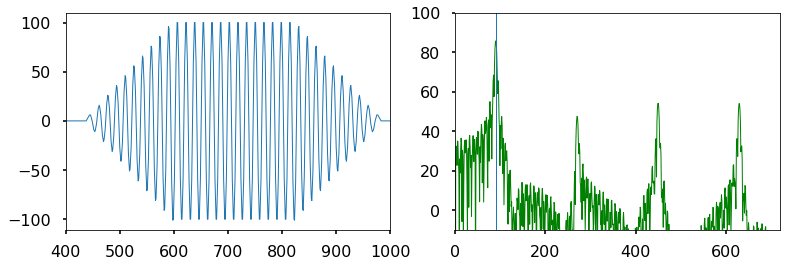

In [25]:
filt2 = ralatone(impulse(2000), 11, 6, half_period, 24, 10)

subplot(121); plot(filt2); xlim(400, 1000)
subplot(122); freq2 = psr(filt2); peak2 = len(filt2)/half_period/2; axvline(peak2)
peak2, 500/fs, freq2.argmax(), freq2[200:1000].max(), filt2.sum()

In this case as well an extra layer of integration helps:
it gives us 47 dB of suppression of the third harmonic.

(93.89160294194134, 46.58972859019051)

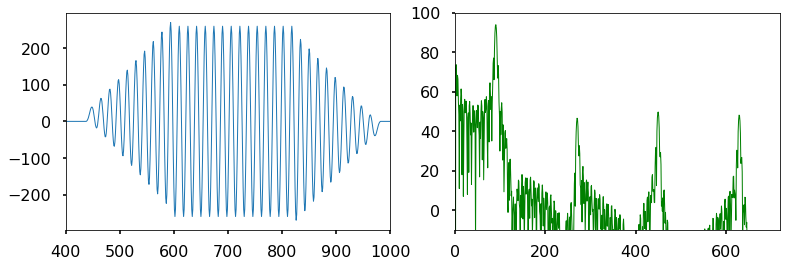

In [26]:
subplot(121); plot(filt2.cumsum()); xlim(400, 1000)
subplot(122); freq23 = psr(filt2.cumsum())
freq23.max(), freq23[200:400].max()

(520, 530)

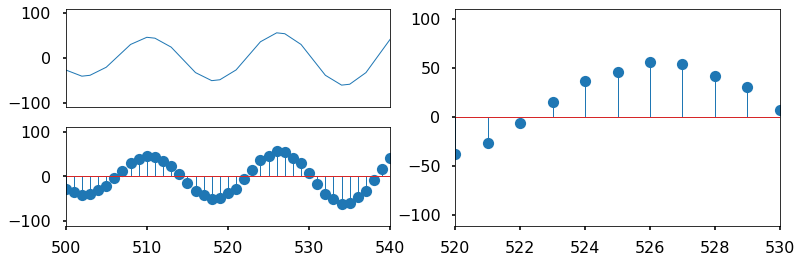

In [27]:
subplot(221).xaxis.set_visible(False); plot(filt2); xlim(500, 540)  # there must be an easier way to hide ticks
subplot(223, sharex=gca()); stem(filt2, use_line_collection=True)
subplot(122); stem(filt2, use_line_collection=True); xlim(520, 530)

array([81.38502476, 84.93907826, 85.72287353, 84.06081591, 79.52019563,
       69.63727469, 59.10261034])

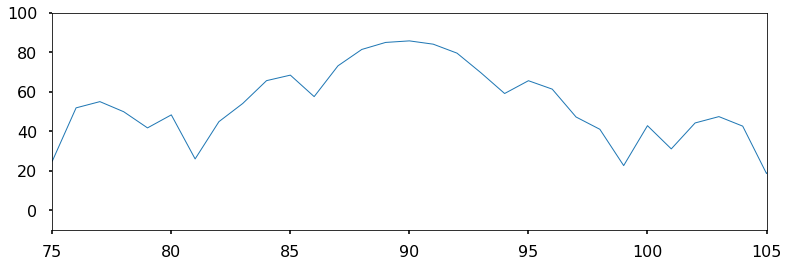

In [28]:
plot(freq2); xlim(75, 105); ylim(-10, 100)
freq2[88:95]

In [29]:
fs / (len(filt2) / arange(88, 95))

array([ 978.45726199,  989.57609451, 1000.69492703, 1011.81375956,
       1022.93259208, 1034.0514246 , 1045.17025712])

So this version of the filter has 85.7 dB response at 1000 Hz, 85 Hz response at 990 Hz, and drops off to 81 dB at 978 Hz or 1022 Hz.  By the time we're up to soprano C at 1046 Hz we're down to 59 dB, 27 dB attenuated!  This is pretty non-ideal for recognizing soprano C but it's definitely a sharper response.  It might even be a little
*too* sharp.
Everything outside the immediate neighborhood of the peak is down by at least 30 dB.  Probably by optimizing the piecewise-linear wave shape more we could get a few more dB, but I'm thinking probably going to a second-order
approximation we'd get more like 60 dB if we care about that.

The support of the kernel is about 30 ms long, which means about 15 ms of latency.  That's acceptable for 
interpreting whistled robot commands; at
120 bpm in 4/4 time, a quarter-note is 500 ms, so that's half of a 64th note, and it's one cycle of 66.7 Hz (a bit above C2, deep C, the 16th key on an 88-key piano).  I think
you can't do *much* better than that; some latency is inherent
to the problem of detecting a tone around 1 kHz with a frequency precision of a few percent.

For musical processing 15ms is a little longer than would be ideal but not totally unacceptable.  A time-domain
algorithm that correlates the current waveform period with an average of the last few waveform periods can probably
do a better job for lower frequencies.

Downconversion and downsampling
----

Downconversion might be a worthwhile thing to do for a few different reasons.  First, it means we can decimate
harder, which reduces the amount of work done per frequency; if we're recognizing
several tones (like 8 for DTMF or the 17 notes of the 12TET scale within my whistling range) most of the work
can easily be per-tone despite decimation, despite the higher-sample-rate work done up front in the integrators.
Second, it reduces the frequency error from rounding off the lag to an integer number of samples.  (There are 
some alternative strategies for that: trying to dither the lag or decimation,
using a multi-cycle more accurate lag for one
of the feedback combs, interpolating lagged or decimated samples, etc.)

A few multiplication-free waveforms to downconvert by "multiplying" with are [1, -1], [0, 1, 0, -1], [1, 1, -1, -1], and [0, 1, 1, 0, -1, -1].  The first one is $f_s/2$, the next two are $f_s/4$, and the last one is $f_s/6$; with $f_s$ of 16 kHz they would be respectively 8 kHz, 4 kHz, and 2.667 kHz.  None of these would help.  But maybe
you could do a single multiplication per sample and share that over many or all frequencies.

If you're only detecting tones in the 600-1600 Hz range, it might be worthwhile to start your downconversion by downsampling to something like 4 or 5 ksps.  At 5 ksps the multiplication-free waveforms above become 2500, 1250, and 833 Hz.
For tone detection I think you can get by with simple Hogenauer downconversion without post-emphasis, because it doesn't matter if the relative amplitudes of the tones change a bit.

Consider a very nearby downconversion frequency like 500 Hz (period 32 samples at 16 kHz).  That would reduce D#5 (622.2540 Hz, the lowest note I can whistle) down to 122.3 Hz, so you could decimate to 489 samples per second.  But you need a pretty sharp high-pass antialiasing filter to attenuate 500-122.3 = 377.7 Hz by 30 dB or more to avoid false
detections; it's less than an octave below.  (F#4, F# above middle C, is 370 Hz.)  So a somewhat more distant downconversion frequency like 400 Hz might be better, putting D#5 at 222.3 Hz, which you would decimate to 889 samples per second.  Then your aliasing filter just has to kill 177.7 Hz and below before mixing,
which seems a lot more doable.

But downconversion to 400 Hz stops helping you above about 880 Hz (A5, so the downconversion multiplication is only shared over 7 notes), which becomes 480 Hz and 1920 I/Q samples per second.  That's barely even decimated!  You'd probably want a second mixing frequency, with its own antialiasing filter, but it won't save you as much because it can't downconvert quite so low.  Like, 600 Hz would work: A#5 is 932 Hz, and would downconvert to 332 Hz, aliasing with 268 Hz, which is similarly far below.  But 332 Hz is only 30% lower than 480 Hz was, so you've added a lot of complexity for minimal savings of work, and you zoom past downconverted 480 Hz again (1080 Hz) after only three notes: A#5, B5, C6.

It might be best to bite the bullet and not downconvert.  And *up*sampling would also ameliorate the frequency
precision problem.

Some thoughts on performance
-----

Suppose you want to recognize 17 musical notes between 600 and 1600 Hz in a 16 ksps signal, without
downconversion.
Two levels of integration ($b$ and $c$) takes 32000 adds per second.  Then we decimate to 17 rates between
2400 and 6400 samples per second:


In [30]:
whistleable_notes = [round(freq, 3) for freq in [440 * 2**(i/12) for i in range(40)] if 600 < freq < 1600]
print(whistleable_notes)
decimations = (array(whistleable_notes) * 4 + 0.5).astype(int)
len(decimations), decimations

[622.254, 659.255, 698.456, 739.989, 783.991, 830.609, 880.0, 932.328, 987.767, 1046.502, 1108.731, 1174.659, 1244.508, 1318.51, 1396.913, 1479.978, 1567.982]


(17,
 array([2489, 2637, 2794, 2960, 3136, 3322, 3520, 3729, 3951, 4186, 4435,
        4699, 4978, 5274, 5588, 5920, 6272]))

For each of these decimated signals we calculate $d$ and $e$, the feedforward comb filter thing for low pass
filters, and $f$ and $g$, the integrator resonator
thingie.  So we have four subtractions per sample in each of these, for a total of 279,560 per second.

In [31]:
4 * decimations.sum()

279560

Then every so often, like maybe 100 times a second, we calculate some windows ($h$ and $j$) over each of those frequencies, resulting in another 3400 subtractions.

In [32]:
len(decimations) * 2 * 100

3400

All of this adds up to 315 thousand adds and subtracts per second, almost 20 per sample.  This is pretty cheap
compared to the Goertzel algorithm, which is the standard approach to tone detection.

In [33]:
cost = 3400 + 279560 + 32000
cost, cost/16000

(314960, 19.685)

This suggests that probably it would be better to do a third level of integration at a cost of another 16000 adds per second (5%)
in order to get another 20 dB or so of low-pass filtering.
We could imagine decimating the second and third integrators in such cases if that cost was important --- or
using the integrators to interpolate extra samples to reduce the phase noise from the decimators.

Let's play: whistle detection
----

First I whistled at my computer in the kitchen
and recorded it using sox.  Analysis of the sound in Audacity shows lots of noise and some harmonic generation
due to clipping, but a pretty clear signal in the 800-1800 Hz range.

In [34]:
%%bash
# sudo apt install sox
# uncomment to rerecord:
# rec -q -r 16000 testwhistle.wav trim 0 0:05
play -q testwhistle.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable


80000

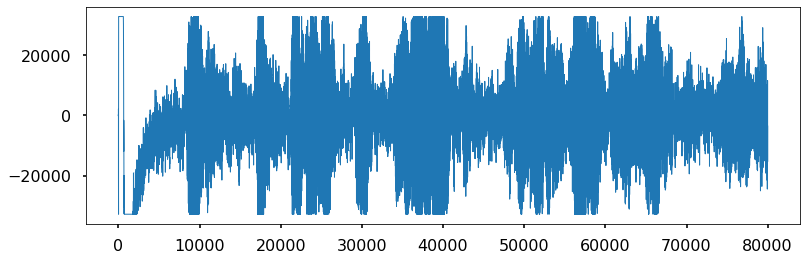

In [35]:
# From vocoder.py, by way of https://nbviewer.org/url/canonical.org/~kragen/sw/dev3/bleep-ultrasound-barcodes.ipynb
# slightly hacked
import wave

def read_wav(filename, rate):
    "Returns a Numpy array of the left channel of a .wav file."
    with wave.open(filename) as wav:
        assert wav.getnchannels() == 2, filename
        assert wav.getsampwidth() == 2, filename
        assert wav.getframerate() == rate, filename
        nframes = wav.getparams().nframes
        samples = wav.readframes(nframes)

    # XXX note that the right channel is still stored in memory, just
    # inaccessible through this view
    return ndarray(shape=(nframes*2,), dtype='<h', buffer=samples)[::2]

def write_wav(filename, samples, rate):
    buf = zeros(len(samples) * 2, dtype='<h')
    buf[1::2] = buf[::2] = numpy.round(samples)
    with wave.open(filename, 'w') as outf:
        outf.setnchannels(2)
        outf.setsampwidth(2)
        outf.setframerate(rate)
        outf.writeframes(buf.tobytes())

def dump(filename, sig, rate):
    max_s = max(sig)
    min_s = min(sig)
    sig = (sig - (max_s + min_s)/2) / (max_s - min_s)
    write_wav(filename, 32767 * sig, rate)

testwhistle = read_wav('testwhistle.wav', 16000)
plot(testwhistle)
len(testwhistle)

This is a bit slow; it's doing the iteration for the recursive filters in interpreted Python, one sample at a time,
and it's not doing
any decimation.  It's running five times faster than real time, but on a dual-core 2.2GHz Pentium T4400.
But it's not really realizing the potential for speed in this prototype form.

In [36]:
%%time
test_detect = ralatone(testwhistle, 11, 3, half_period, 12, 8)  # filter parameters from filt above

CPU times: user 796 ms, sys: 14.2 ms, total: 810 ms
Wall time: 955 ms


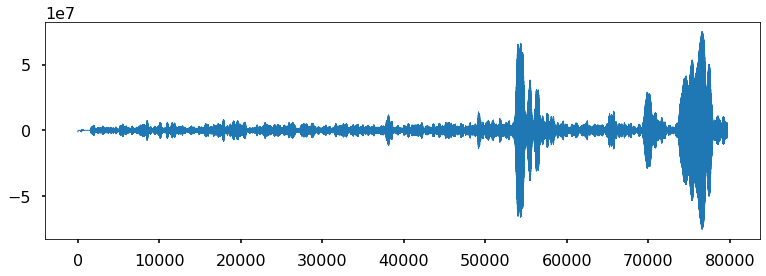

In [37]:
plot(test_detect)
dump('testdetect.wav', test_detect, 16000)

Looking at the spectrogram in Audacity it looks like those big pulses really do have whistles at 1 kHz at
those times, except for the one around 66000, which seems to be a white noise thing.  There's a whistle
around 875 Hz before the first big pulse, which seems to get nicely attenuated, and a whistle after it around
1090 Hz which also gets filtered out.  So it pretty much is working, but you might have to set some sort
of dynamic amplitude threshold to exclude white noise.

In [38]:
%%bash
play -q testdetect.wav
play -q testwhistle.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 0-bit Unknown or not applicable


Well, it certainly does seem to be resonating around 1 kHz, and it's not shooting off to infinity despite
the possibility that floating-point roundoff could cause it to do so.

(79666, 80000)

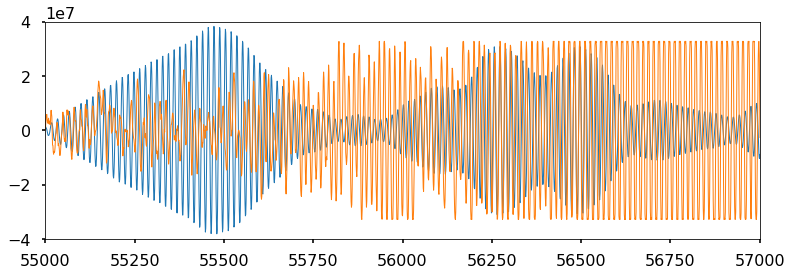

In [39]:
plot(test_detect)
plot(testwhistle[len(testwhistle) - len(test_detect):] * 1e3)
xlim(55000, 57000)
ylim(-4e7, 4e7)
len(test_detect), len(testwhistle)

In [40]:
half_period

8

In [41]:
16000/18

888.8888888888889

Okay, let's try an 889-Hz detection.

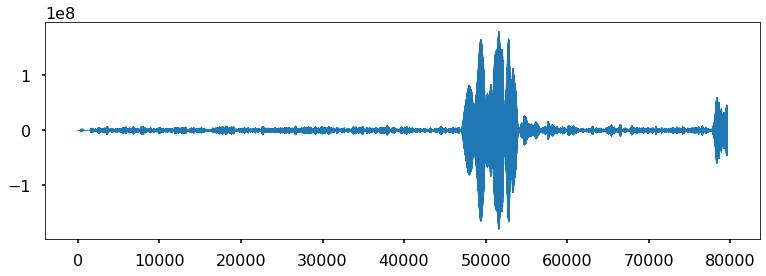

In [42]:
test_detect2 = ralatone(testwhistle, 11, 3, l3=9, n=12, m=8)
plot(test_detect2)
dump('testdetect2.wav', test_detect2, 16000)

Again, there really are big pulses around 875 Hz in Audacity's spectrogram at the positions where I see big pulses.

In [43]:
%%bash
play -q testdetect2.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable


(48500, 50500)

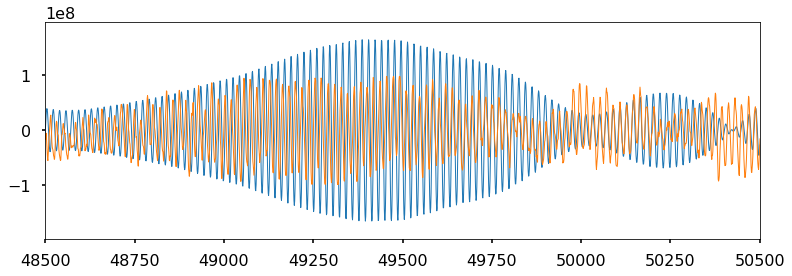

In [44]:
plot(test_detect2)
plot(testwhistle[len(testwhistle) - len(test_detect2):] * 3e3)
xlim(48500, 50500)

So it seems that we're able to separate at least two whistle tones.  If we add them back together
we can get just those two whistles.

In [45]:
dump('testdetect12.wav', test_detect[40:] + test_detect2, 16000)

In [46]:
%%bash
play -q testdetect12.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable


Let's try a third frequency.

In [47]:
16000/14

1142.857142857143

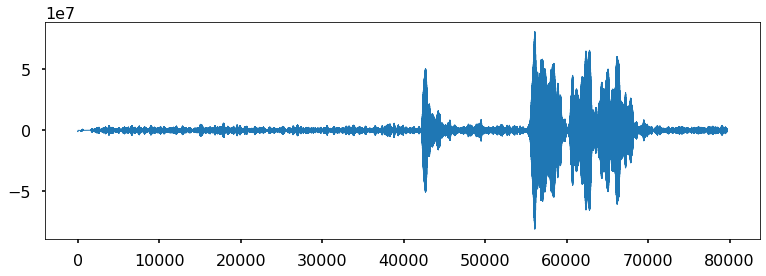

In [48]:
test_detect3 = ralatone(testwhistle, 11, 3, l3=7, n=12, m=8)
plot(test_detect3)
dump('testdetect3.wav', test_detect3, 16000)

Testing with an additional integrator doesn't seem to show any real difference, probably because
there wasn't a significant amount of noise on the third harmonic.  You can see a little more
low-frequency noise and in particular it amplified the giant impulses at the beginning of the recording.

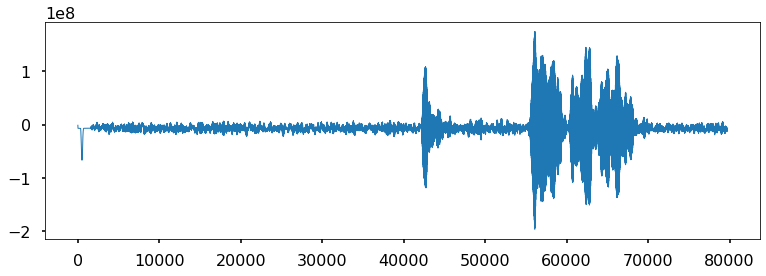

In [49]:
dt3_smoothed = test_detect3.cumsum()
plot(dt3_smoothed)
dump('smoothed3.wav', dt3_smoothed, 16000)

In [50]:
%%bash
play -q testdetect3.wav
play -q smoothed3.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 0-bit Unknown or not applicable


In [51]:
dump('testdetect123.wav', test_detect[40:] + test_detect2 + test_detect3[80:], 16000)

In [52]:
%%bash
play -q testdetect123.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable


In [53]:
dump('testdetect13.wav', test_detect[40:] + test_detect3[80:], 16000)
dump('testdetect23.wav', test_detect2 + test_detect3[80:], 16000)

In [54]:
%%bash
play -q testwhistle.wav
play -q testdetect.wav
play -q testdetect3.wav
play -q testdetect13.wav
play -q testdetect2.wav
play -q testdetect3.wav
play -q testdetect23.wav
play -q testwhistle.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 0-bit Unknown or not applicable


It seems like at least one of these filters, probably the #3 1143-Hz one,
is letting through two different whistled notes, which is suboptimal;
but all of them have
pretty close to the same volume, and they do have pretty reasonable selectivity.

How long is this taking?

In [55]:
array([2.2e9, 1]) / 16000 / 5

array([2.75e+04, 1.25e-05])

28000 cycles or 13 $\mu$s per sample.  How long does an addition or subtraction cost in Numpy?

In [56]:
%%time
xx = testwhistle
for i in range(1000):
    xx = xx.cumsum()

len(xx)

CPU times: user 466 ms, sys: 4.28 ms, total: 471 ms
Wall time: 489 ms


80000

In [57]:
500/80000

0.00625

A cumsum takes 6.25 ns per sample.  So it's taking about 2000 cumsums' worth due to the loop in Python.

Faster filtering with Numpy
====

In [Fast recursive comb-filter oscillator in Numpy](fast-comb-oscillator.ipynb) I came up with this fast implementation of the slow feedback comb:

In [58]:
def osc_numpy(x, n):
    h = (len(x) + n-1)//n
    y = zeros(n*h, dtype=x.dtype)
    y[:len(x)] = x
    y.shape = (h, n)
    flips = (-1)**arange(h)
    flips.shape = (h, 1)
    y *= flips
    y.cumsum(axis=0, out=y)
    y *= flips
    y.shape = (n*h,)
    return y[:len(x)]

With a version of the feedforward comb that doesn't change the data length,
we get a faster version of the same tone detection algorithm, though
still without decimation:

In [59]:
def forward_comb(x, lag):
    return concatenate((x[:lag], x[lag:] - x[:-lag]))

def fast_tone(x, l1, l2, l3, n, m):
    return fast_filter(x.cumsum().cumsum(), l1, l2, l3, n, m)

def fast_filter(c, l1, l2, l3, n, m):
    d = forward_comb(c, l1)
    e = forward_comb(d, l2)
    g = osc_numpy(osc_numpy(e, l3), l3)
    h = forward_comb(g, 2 * n * l3)
    return forward_comb(h, 2 * m * l3)

In [60]:
%%time
test_detect3_1 = ralatone(testwhistle, 11, 3, l3=7, n=12, m=8)

CPU times: user 798 ms, sys: 339 µs, total: 798 ms
Wall time: 825 ms


In [61]:
%%time
test_detect3_2 = fast_tone(testwhistle, 11, 3, l3=7, n=12, m=8)

CPU times: user 15.8 ms, sys: 255 µs, total: 16.1 ms
Wall time: 15.6 ms


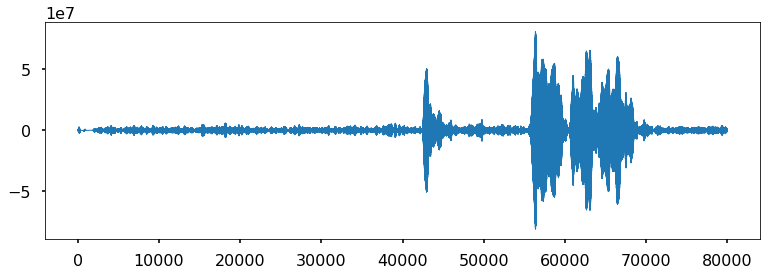

In [62]:
plot(test_detect3_2)

In [63]:
dump('testdetect3-fast.wav', test_detect3_2, 16000)

In [64]:
%%bash
play -q testdetect3-fast.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable


In [65]:
len(test_detect3_2), len(test_detect3)

(80000, 79706)

It seems to produce identically the same results, but in 20 ms instead of 776 ms, 40$\times$ faster.

38.8

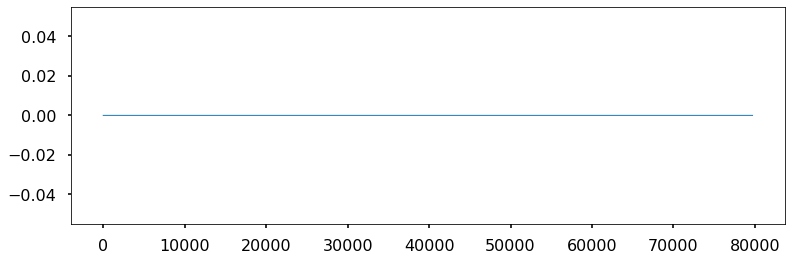

In [66]:
plot(test_detect3_2[80000-79706:] - test_detect3)
776/20

Let's try filtering a decimated signal.

In [67]:
%%time
test_detect4 = fast_filter(testwhistle.cumsum().cumsum()[::4], 2, 1, l3=3, n=12, m=8)

CPU times: user 6.25 ms, sys: 0 ns, total: 6.25 ms
Wall time: 14.4 ms


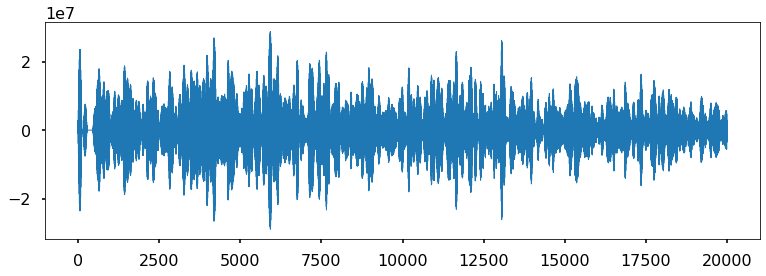

In [68]:
plot(test_detect4)
dump('test_detect4.wav', test_detect4, 4000)

Hmm, that didn't work very well: though it did run four times as fast (10 ms instead of 40 ms)
it produced useless results.  To my surprise SoX can decode 4ksps files:

In [69]:
%%bash
play test_detect4.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable

test_detect4.wav:

 File Size: 80.0k     Bit Rate: 128k
  Encoding: Signed PCM    
  Channels: 2 @ 16-bit   
Samplerate: 4000Hz       
Replaygain: off         
  Duration: 00:00:05.00  

In:100%  00:00:05.00 [00:00:00.00] Out:20.0k [      |      ]        Clip:0    
Done.


Let's see what the impulse response of our filter is.  We still have an impulse in `x`:

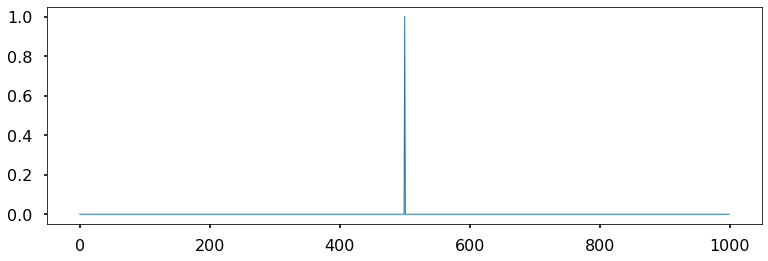

In [70]:
plot(x)

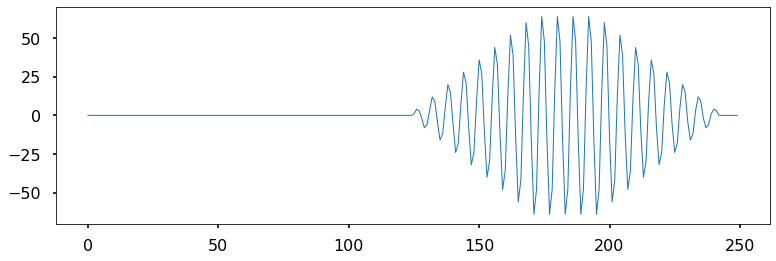

In [71]:
decir = fast_filter(x.cumsum().cumsum()[::4], 2, 1, l3=3, n=12, m=8)
plot(decir)

Okay, but what frequency and Q factor is that?

42

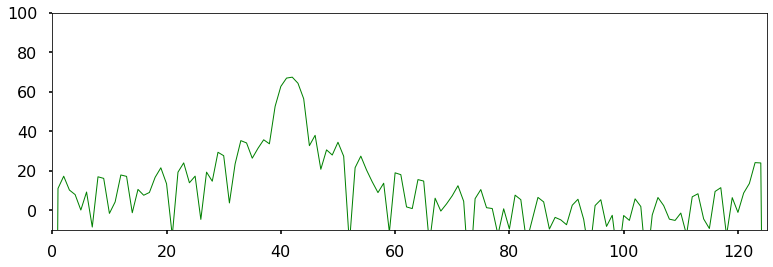

In [72]:
decpsr = psr(decir)
decpsr.argmax()

42 cycles in the FFT input is 5.95 samples per cycle:

In [73]:
len(decir)/42 

5.9523809523809526

Which works out to 672 Hz.  Maybe that's why it didn't detect anything: the whistles were all higher than that.

In [74]:
4000/5.95

672.2689075630252

What if we use l3=2, that is, 4 decimated samples per cycle, like we've been saying would be ideal?  That should get us into whistle range: 1008 Hz.

1008.0

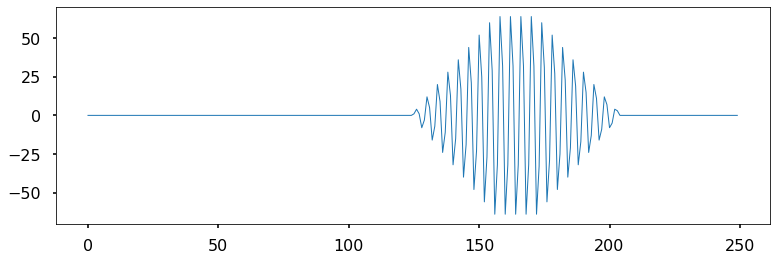

In [75]:
plot(fast_filter(x.cumsum().cumsum()[::4], 2, 1, l3=2, n=12, m=8))
672 * 3/2

In [76]:
%%time
test_detect5 = fast_filter(testwhistle.cumsum().cumsum()[::4], 2, 1, l3=2, n=12, m=8)

CPU times: user 6.57 ms, sys: 165 µs, total: 6.74 ms
Wall time: 6.34 ms


%%timeit gives me times from 5.5&ndash;13 milliseconds when I recompute that cell repeatedly.  How does the result look?

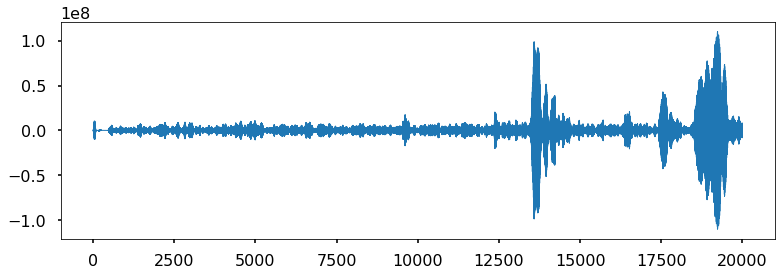

In [77]:
plot(test_detect5)

That looks more like it!  It's almost the same as my first detection result, though it begins a little earlier and differs slightly in detail (and in magnitude):

75121195.0

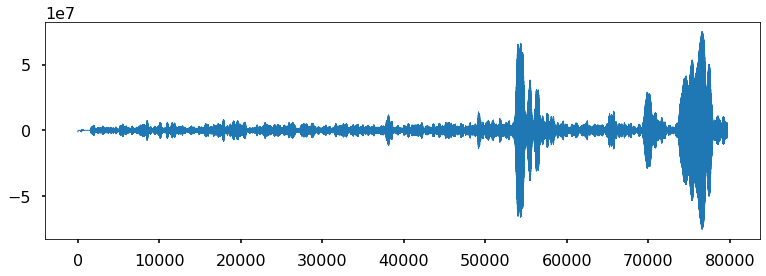

In [78]:
plot(test_detect)
test_detect.max()

In [79]:
%%time
dump('test_detect5.wav', test_detect5, 4000)

CPU times: user 4.2 ms, sys: 7.62 ms, total: 11.8 ms
Wall time: 11.5 ms


In [80]:
%%bash
play test_detect5.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable

test_detect5.wav:

 File Size: 80.0k     Bit Rate: 128k
  Encoding: Signed PCM    
  Channels: 2 @ 16-bit   
Samplerate: 4000Hz       
Replaygain: off         
  Duration: 00:00:05.00  

In:100%  00:00:05.00 [00:00:00.00] Out:20.0k [      |      ]        Clip:0    
Done.


How much of that is the preprocessing?

In [81]:
%%timeit
twcc = testwhistle.cumsum().cumsum()

1.38 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
twcc = testwhistle.cumsum().cumsum()

In [83]:
%%timeit
fast_filter(twcc[::4], 2, 1, l3=2, n=12, m=8)

3.44 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Holy shit, that's a lot faster than I thought.  3 ms per frequency to process 5 seconds of audio, plus 1.35 ms
of shared preprocessing.  If we assume 2.5 instructions per clock, single-threaded, how many instructions is that per sample?

In [84]:
2.2e9 * 2.5 * array([1.35e-3, 2.99e-3]) / 16000 / 5

array([ 92.8125, 205.5625])

206 instructions per sample per tone, plus 93 instructions per sample of preprocessing.  Not quite Arduino speed,
because we'd need 58 million instructions per second to recognize all 17 tones that way:

In [85]:
(93 + 17 * 206) * 16

57520

But usually Numpy (which doesn't run on Arduinos)
is about 5$\times$ slower than native code, and this is still running a 12+8-cycle window 4000
times a second instead of, say, 40, 50, or 100, and decimating that would eliminate a significant percentage
of the remaining operations
per sample.  So I think this is strongly suggestive that this filter could be squeezed into an Arduino.

Frequency localization within a passband with phase vocoder techniques
-----

Another interesting possibility, one which for whistle detection in particular could eliminate
the need to use a large, expensive filter bank,
is using a phase-vocoder-like technique to determine the frequency of a
(single, by hypothesis) whistle tone that fits into successive windows of the filter,
by using the phase signal I've been totally
not graphing at all so far.  This would involve using a shorter time window to capture a wider range of frequencies:

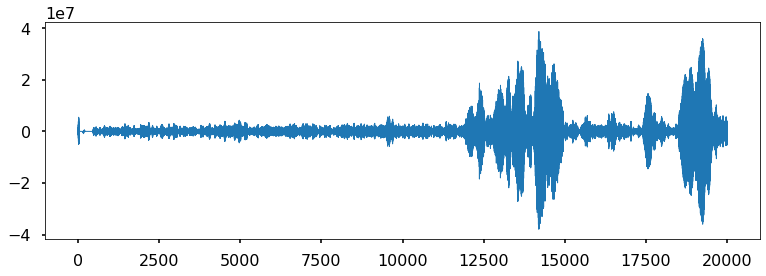

In [86]:
test_detect6 = fast_filter(twcc[::4], 2, 1, l3=2, n=6, m=4)
plot(test_detect6)

In [87]:
dump('test_detect6.wav', test_detect6, 4000)

In [88]:
%%bash
play -q testwhistle.wav
play test_detect6.wav

play WARN alsa: can't encode 0-bit Unknown or not applicable
play WARN alsa: can't encode 0-bit Unknown or not applicable

test_detect6.wav:

 File Size: 80.0k     Bit Rate: 128k
  Encoding: Signed PCM    
  Channels: 2 @ 16-bit   
Samplerate: 4000Hz       
Replaygain: off         
  Duration: 00:00:05.00  

In:100%  00:00:05.00 [00:00:00.00] Out:20.0k [      |      ]        Clip:0    
Done.


Here we can extract the phase signal, which looks surprisingly clean; later we'd have to unwrap it:

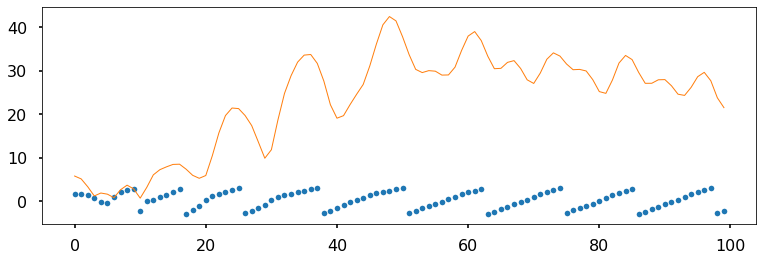

In [89]:
plot(arctan2(test_detect6[14000:14400:4], test_detect6[14001:14400:4]), '.')       # phase with dots
plot((test_detect6[14000:14400:4]**2 + test_detect6[14001:14400:4]**2)**0.5 / 1e6) # plot the amplitude too

It looks like the phase makes about 9 revolutions over those 400 samples (100 ms), so the whistle being detected
there is about 90 Hz off from the center frequency which I computed above as 1008 Hz.  I'm not sure if that makes it 1098 Hz or 918 Hz.  Also it looks like in this case maybe we could decimate this phase signal by another factor
of 3 or 4 before we lost the ability to unwrap it.  Let's look at a lower-amplitude section:

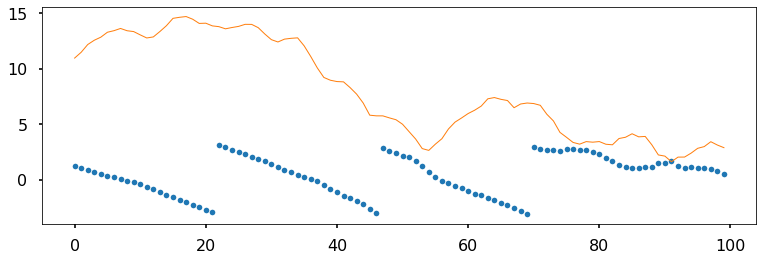

In [90]:
plot(arctan2(test_detect6[17500:17900:4], test_detect6[17501:17900:4]), '.')
plot((test_detect6[17500:17900:4]**2 + test_detect6[17501:17900:4]**2)**0.5 / 1e6)

That's an even cleaner, nicer phase shift signal.  How about a region when we have nothing but noise?

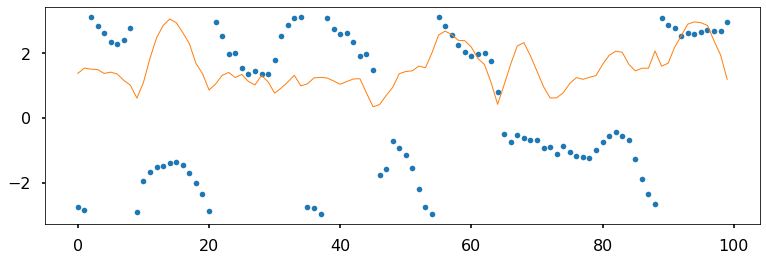

In [91]:
plot(arctan2(test_detect6[4000:4400:4], test_detect6[4001:4400:4]), '.')
plot((test_detect6[4000:4400:4]**2 + test_detect6[4001:4400:4]**2)**0.5 / 1e6)

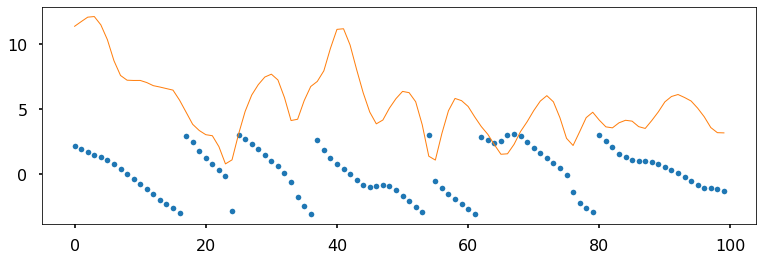

In [92]:
plot(arctan2(test_detect6[19500:19900:4], test_detect6[19501:19900:4]), '.')
plot((test_detect6[19500:19900:4]**2 + test_detect6[19501:19900:4]**2)**0.5 / 1e6)

This ought to work well for a channel vocoder for making robot noises
-----

I'd tried to figure out how to do a channel vocoder with this sort of thing previously without success,
and ended up using largish FIR filters instead, which ran barely faster than real time, and for some
reason upsampling a signal dozens of times.

With these results, though, it seems like it should be pretty straightforward: you use the above algorithm
to analyze the voice signal amplitude in each of 8&ndash;20 frequency bands, choosing the window length to be short
enough that the bands are quite wide.  Then you use the same filters to analyze the carrier signal amplitude in
the same bands into corresponding components,
and you multiply each component by the amplitude measured for that
component of the voice signal, ensure that the delays are matched up, and add them back together.

Covering 30 Hz to 6000 Hz with 20 bands requires each band to have a Q of no more than about 8:

In [99]:
print([round(30*(6000/30)**(i/19), 2) for i in range(20)])

[30.0, 39.65, 52.4, 69.25, 91.53, 120.96, 159.87, 211.29, 279.24, 369.05, 487.74, 644.61, 851.93, 1125.93, 1488.05, 1966.64, 2599.15, 3435.09, 4539.88, 6000.0]


Q should be about 5 or 6 for 16 bands:

In [101]:
print([round(30*(6000/30)**(i/15), 2) for i in range(16)])

[30.0, 42.71, 60.8, 86.56, 123.23, 175.44, 249.77, 355.58, 506.22, 720.67, 1025.99, 1460.64, 2079.43, 2960.38, 4214.53, 6000.0]


In [103]:
(42.71*30)**.5

35.79525108167283

In [105]:
1/((array([42.7, 30]) - 35.8) / 35.8)

array([ 5.1884058 , -6.17241379])

And Q should be like 2 or 3 for 8 bands:

In [106]:
print([round(30*(6000/30)**(i/7), 2) for i in range(8)])

[30.0, 63.95, 136.32, 290.59, 619.43, 1320.43, 2814.7, 6000.0]


In [108]:
mid = (30*64)**.5
1/((array([30, 64]) - mid) / mid), mid

(array([-3.1711119,  2.1711119]), 43.81780460041329)